In [1]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def vis(model, dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)
    model.eval()

    # create dataloaders for training and validation
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Run the data through the model and store the output
    outputs = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs_batch = model(images)
            outputs.append(outputs_batch.cpu().numpy())
            labels.append(targets.cpu().numpy())

    outputs = np.concatenate(outputs, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Apply PCA
    # pca = PCA(n_components=2)
    # pca.fit(outputs)
    # pca_transformed = pca.transform(outputs)
    
    # # Plot the results
    # fig, ax = plt.subplots()
    # for i in range(len(data.classes)):
    #     indices = np.where(labels == i)[0]
    #     ax.scatter(pca_transformed[indices, 0], pca_transformed[indices, 1], label=data.classes[i])
    # ax.legend()
    # plt.show()
    
    
    # t-SNEで埋め込みデータを2次元に削減
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(outputs)
    fig, ax = plt.subplots()
    for i in range(len(dataset.classes)):
        indices = np.where(labels == i)[0]
        ax.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=dataset.classes[i])
    ax.legend()
    plt.show()

    
    # k-NNで分類
    thr = 100
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(outputs[:thr], labels[:thr])

    print(f"train: {len(outputs[:thr])}")
    print(f"test: {len(outputs[thr:])}")

    # 埋め込みデータに対して分類の精度を計算
    train_preds = knn.predict(outputs[thr:])
    train_accuracy = np.mean(train_preds == labels[thr:])
    print(f"Training accuracy: {train_accuracy:.3f}")

In [2]:
def display_dataset(dataset):
    # クラスの数とクラス名を取得
    num_classes = len(dataset.classes)
    class_names = dataset.classes
    
    print(f"num_data: {len(pipe_dataset)}")
    print(f"num_classes: {num_classes}")
    print(f"class_names: {class_names}")
    
    # 各クラスのサンプル画像を表示
    fig, axs = plt.subplots(nrows=num_classes, ncols=4, figsize=(12, 3*num_classes))
    
    for i, class_name in enumerate(class_names):
        # クラスに属する画像のインデックスを取得
        indices = torch.where(torch.tensor(dataset.targets) == i)[0]
        # クラスからランダムに4つの画像を選択
        sample_indices = torch.randperm(len(indices))[:4]
        
        for j, sample_idx in enumerate(sample_indices):
            # 画像を取得し、テンソルからNumPy配列に変換
            image, _ = dataset[indices[sample_idx]]
            image = image.numpy().transpose((1, 2, 0))
            
            # 画像を表示
            axs[i, j].imshow(image)
            axs[i, j].set_title(class_name)
            axs[i, j].axis("off")
    
    plt.tight_layout()
    plt.show()

In [3]:
# resize & to_tensor
resize = transforms.Compose([
    transforms.Resize((224, 224)),  # resize image to 224x224
    transforms.ToTensor(),  # convert image to tensor
])

# resize & to_tensor & normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize image to 224x224
    transforms.ToTensor(),  # convert image to tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

num_data: 200
num_classes: 2
class_names: ['NG', 'OK']


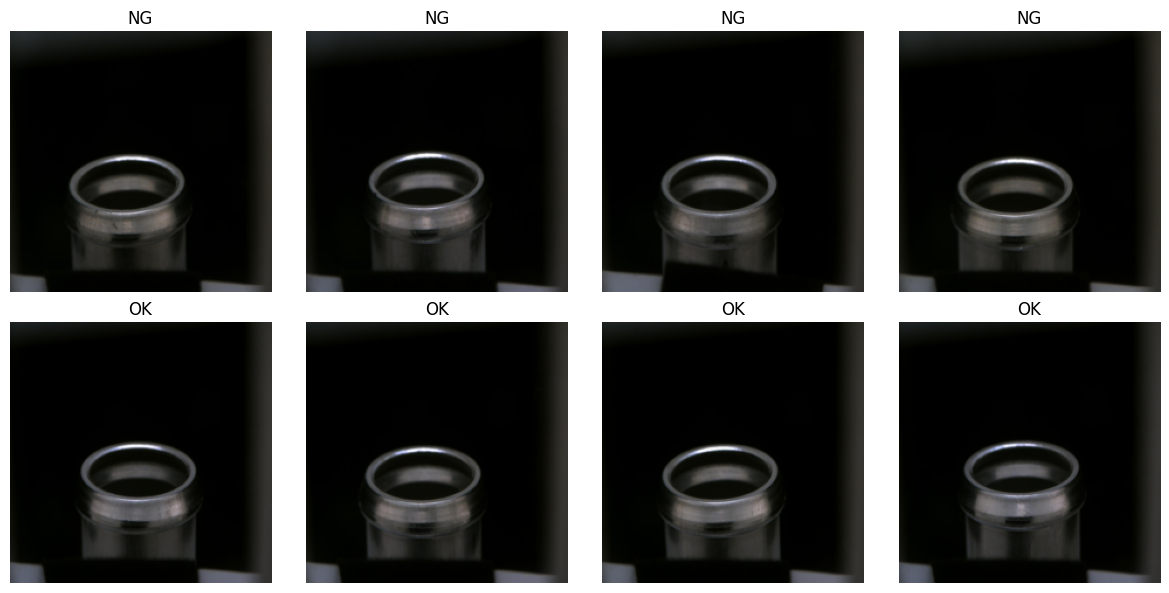

In [4]:
# Pipe
# Load the data
data_dir = '/workspace/datasets/pipe'

# create datasets for training and validation
pipe_dataset = datasets.ImageFolder(data_dir, transform=resize)
display_dataset(pipe_dataset)
pipe_dataset = datasets.ImageFolder(data_dir, transform=transform)

Using cache found in /home/duser/.cache/torch/hub/facebookresearch_dinov2_main


Using device: cuda


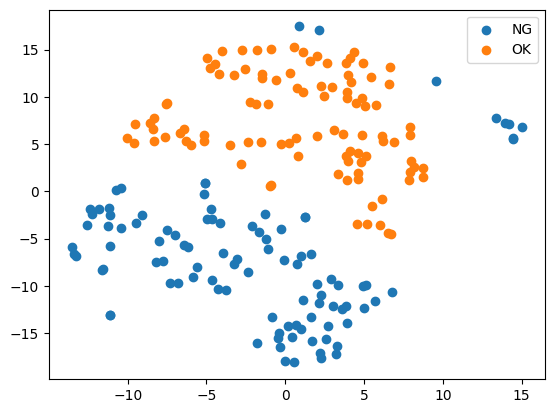

train: 100
test: 100
Training accuracy: 0.980


In [5]:
# DINOv2
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14') 
vis(dinov2, pipe_dataset)

Using cache found in /home/duser/.cache/torch/hub/facebookresearch_dino_main


Using device: cuda


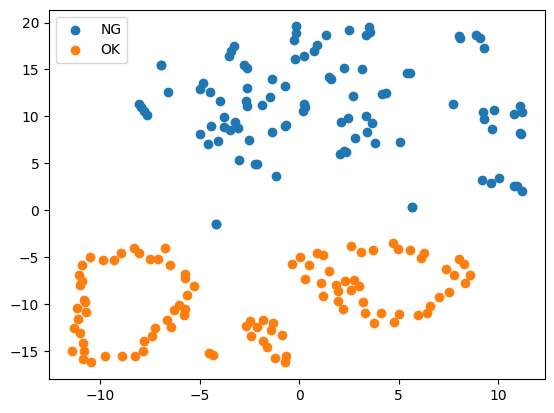

train: 100
test: 100
Training accuracy: 0.970


In [6]:
# DINOv1
dinov1 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
vis(dinov1, pipe_dataset)